In [1]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

## Reading the training data

In [2]:
df_raw_x = pd.read_csv('train.csv')
df_raw_y = pd.read_csv('test.csv')

# create a copy of the df to preserve the raw data
# df_train = df_raw_x.copy()
# df_test = df_raw_y.copy()

In [3]:
df_agg = pd.concat([df_raw_x, df_raw_y], axis = 0, sort = False)

In [4]:
pd.set_option("display.max_columns", 100)

## Data Processing

#### Define a check function for columns with missing values to help check the data processing status

In [5]:
def get_Nan(dataframe):
    total_nans=dataframe.isnull().sum().sum()
    print('Total Number of NaNs:')
    print(total_nans)
    print('-'*50)
    
    percent_nans=(total_nans/(dataframe.shape[0]*dataframe.shape[1]))*100
    print('Percentage of NaNs in total data:')
    print(percent_nans)
    print('-'*50)

    print('Number of NaNs per column')
    #Pre-processing steps
    col_nan=pd.DataFrame(dataframe.isnull().sum())
    col_nan=col_nan.reset_index()
    col_nan=col_nan.rename(columns={'index':'column', 0:'total.Nans'})
    #convert to percentage of NaN's per row
    col_nan['total.Nans']=(col_nan['total.Nans']/len(dataframe))*100
    return (round(col_nan.sort_values(by='total.Nans', ascending=False).loc[(col_nan['total.Nans'])>0],ndigits=2))        

In [ ]:
# df_train.corr().SalePrice.sort_values(ascending = False)

##### Fill missing values

In [8]:
# Fill Na of PoolQC with 'NoPool' because in description text Na means that there is no pool
df_agg['PoolQC']=df_agg['PoolQC'].fillna('NoPool')

# Check MiscFeature, in description text Na means there are no extra features so Na will be replaced with 'None'
df_agg['MiscFeature']=df_agg['MiscFeature'].fillna('None')

# Check Alley column, in description text Na means there is no alley access, Na will be replaced with 'NoAccess'
df_agg['Alley']=df_agg['Alley'].fillna('NoAccess')

# Check Fence column, in description text Na means no fence, Na will be replaced with 'NoFence'
df_agg['Fence']=df_agg['Fence'].fillna('NoFence')

# Use square root of lot area to fill missing 'LotFrontage'
df_agg['LotFrontage'] = df_agg['LotFrontage'].fillna(np.sqrt(df_agg['LotArea']))

# Fill missing values with 0s - missing due to no such facilities on the properties
df_agg['GarageYrBlt'] = df_agg['GarageYrBlt'].fillna(df_agg.GarageYrBlt.min() - 1)
# One typo in the test dataset with 2207 as garage year for a 2007-built house
df_agg['GarageYrBlt'] = [2007 if x > 2010 else x for x in df_agg.GarageYrBlt]

df_agg['MasVnrArea'] = df_agg['MasVnrArea'].fillna(0)

# Fill missing values within the test file
df_agg['BsmtUnfSF'] = df_agg['BsmtUnfSF'].fillna(0)
df_agg['GarageArea'] = df_agg['GarageArea'].fillna(0)
df_agg['TotalBsmtSF'] = df_agg['TotalBsmtSF'].fillna(0)
df_agg['BsmtFullBath'] = df_agg['BsmtFullBath'].fillna(0)
df_agg['BsmtHalfBath'] = df_agg['BsmtHalfBath'].fillna(0)
df_agg['BsmtFinSF1'] = df_agg['BsmtFinSF1'].fillna(0)
df_agg['BsmtFinSF2'] = df_agg['BsmtFinSF2'].fillna(0)
df_agg['GarageCars'] = df_agg['GarageCars'].fillna(0)

In [25]:
# get_Nan(df_agg)

In [24]:
# rf_x_test.isnull().sum().sort_values(ascending = False)

#### Adding new features: HouseAge, Vintage, OutdoorArea, TotalBath and PricePerSF

In [12]:
# one obs in training dataset with YrSold < YearRemodAdd
df_agg['HouseAge'] = df_agg.YrSold - df_agg.YearRemodAdd
df_agg['HouseAge'] = [0 if x < 0 else x for x in df_agg.HouseAge]

# one obs in test dataset with YrSold < YearBuilt
df_agg['Vintage'] = df_agg.YrSold - df_agg.YearBuilt
df_agg['Vintage'] = [0 if x < 0 else x for x in df_agg.Vintage]

# one obs in test dataset with YrSold < GarageYrBlt
df_agg['GarageAge'] = df_agg.YrSold - df_agg.GarageYrBlt
df_agg['GarageAge'] = [0 if x < 0 else x for x in df_agg.GarageAge]

df_agg['OutdoorArea'] = df_agg.PoolArea + df_agg.WoodDeckSF + df_agg.OpenPorchSF + df_agg.ScreenPorch + df_agg['3SsnPorch'] + df_agg.EnclosedPorch
df_agg['TotalBath'] = df_agg.FullBath + df_agg.BsmtFullBath
df_agg['TotalLvArea'] = df_agg.GrLivArea + df_agg.TotalBsmtSF# + df_agg.OutdoorArea
df_agg['TotalArea'] = df_agg.OutdoorArea + df_agg.GrLivArea + df_agg.TotalBsmtSF + df_agg.GarageArea

# Create a potential alternative target variable PricePerSF
df_agg['PricePerSF'] = df_agg.SalePrice / df_agg.TotalLvArea

# Consolidate some categorical variables
df_agg['LotShapeBin'] = ['Reg' if x == 'Reg' else 'IR' for x in df_agg.LotShape]
df_agg['PoolBin'] = ['No' if x == 'NoPool' else 'Yes' for x in df_agg.PoolQC]
df_agg['FireplacesBin'] = ['No' if x == 0 else 'Yes' for x in df_agg.Fireplaces]

In [ ]:
# this section is just to test any typo or mistakes in the trainig and test datasets

(df_agg.describe() < 0).sum()
df_agg[df_agg.GarageYrBlt > 2010]
df_agg[df_agg.GarageYrBlt > 1895].GarageYrBlt.describe()
df_agg[df_agg.SalePrice.isnull()]
(df_agg.describe() > 2010).sum()
df_agg.GarageAge.describe()

##### Separate the training dataset 

In [13]:
df_train = df_agg[: 1460]
df_test = df_agg[1460:]
df_train.shape

(1460, 92)

In [14]:
df_agg.shape

(2919, 92)

1.8828757597682129

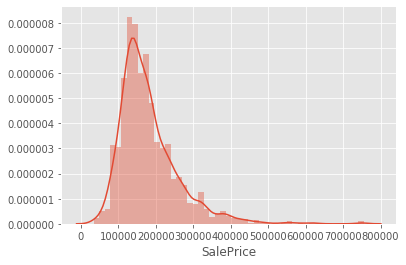

In [15]:
sns.distplot(df_train.SalePrice)
df_train.SalePrice.skew()

#### Take log of SalePrice to reduce skewness

In [ ]:
sns.distplot(np.log(df_train.SalePrice))
np.log(df_train.SalePrice).skew()
# np.log(np.log(df_train.SalePrice)).skew()
# sns.distplot(np.log(np.log(df_train.SalePrice)))

#### Check skewness of PricePerSF - No need to take log

In [ ]:
sns.distplot(df_train.PricePerSF)
df_train.PricePerSF.skew()

In [ ]:
sns.scatterplot(df_train.LotArea, df_train.PricePerSF)
df_train[df_train.LotArea > 100000]

In [ ]:
sns.scatterplot(df_train.TotalBsmtSF, df_train.PricePerSF)

In [ ]:
sns.regplot(df_rf_x.LotFrontage, np.sqrt(df_rf_x.LotArea))

##### Remove outliers: LotArea, TotalBsmtSF

In [16]:
df_train = df_train[df_train.LotArea < 100000]
df_train = df_train[df_train.TotalBsmtSF < 3500]

# 5 outliers from the test dataset in total

## Feature Selection

### 1. Random Forest

In [17]:
from sklearn import tree, ensemble
from sklearn.metrics import mean_squared_log_error

##### Encode categorical variables

In [18]:
# filter out predictor variables for RF selections
rf_agg = pd.concat([df_train, df_test], axis = 0, sort = False)
rf_x = rf_agg.drop(['Id', 'SalePrice', 'PricePerSF'], axis = 1)

# encode categorical variables for RF
df_feature = pd.DataFrame(rf_x.dtypes, columns = ['Type'])
lst_cat = df_feature[df_feature['Type'] == object].index.tolist()
for f in lst_cat:
    u = list(set(rf_x[f]))
    rf_x[f] = [u.index(x) for x in rf_x[f]]
    
# separate the training and test data for RF models
rf_x_train = rf_x[: 1455]
rf_x_test = rf_x[1455:]

In [26]:
# Define a RandForest funciton for recursive RF modeling

def RandForest(x, y, title, perc = 0.01, random = 1, log = True):
    rf = ensemble.RandomForestRegressor()
    rf.set_params(oob_score = True, n_estimators = 500, max_features = 10, random_state = random)
    rf.fit(x, y)

    # print RF oob & score
    print('RF oob score: %.4f'%rf.oob_score_)
    print('RF score: %.4f'%rf.score(x, y))

    # create a dataframe for feature importances
    df_fi = pd.DataFrame(rf.feature_importances_, index = x.columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)
    
    # get the count of features with feature importance > Perc (1% by default)
    row = df_fi[df_fi.Importance > perc].shape[0]
    
    # plot features with FI > Perc (1% by default)
    plt.figure(figsize = (10, 5))
    plt.barh(df_fi.index[:row], df_fi.Importance[:row], color = 'crimson', alpha = 0.75)
    plt.title('Top {} Feature Importances (Over {}%) - {}'.format(row, perc * 100, title))
    
    # separate target varibales of SalePrice and PricePerSF
    agg = pd.concat([df_train, df_test], axis = 0, sort = False)
    y_train = agg[: 1455].SalePrice
    
    if log:
        rmsle = np.sqrt(mean_squared_log_error(y_train, np.exp(rf.predict(x))))
    else:
        rmsle = np.sqrt(mean_squared_log_error(y_train, rf.predict(x) * x.TotalLvArea))
    print('RF RMSLE:', np.round(rmsle, 6))
    print('-' * 50)
    
    lst = df_fi[:row].index.tolist()
    print('Top {} important features by FI: {}'.format(row, lst))
    
    # return list of top features
    return lst, rf

### Random Forest run on SalePrice

RF oob score: 0.8865
RF score: 0.9848
RF RMSLE: 0.049233
--------------------------------------------------
Top 24 important features by FI: ['TotalArea', 'TotalLvArea', 'OverallQual', 'GrLivArea', 'Vintage', 'ExterQual', 'YearBuilt', 'TotalBsmtSF', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'KitchenQual', '1stFlrSF', 'GarageAge', 'BsmtQual', 'HouseAge', 'FullBath', 'LotArea', 'BsmtFinSF1', 'Fireplaces', 'YearRemodAdd', 'FireplaceQu', '2ndFlrSF', 'FireplacesBin']


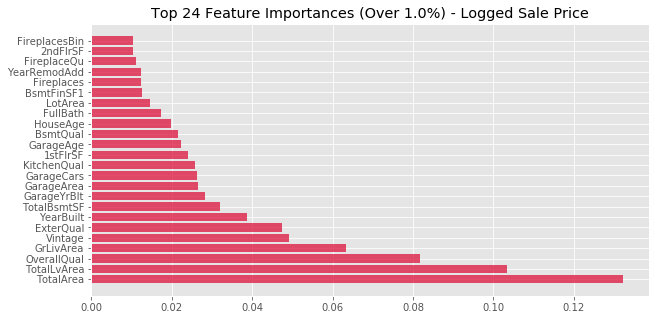

In [27]:
# create the response variable - logged SalePrice
rf_y = np.log(df_train.SalePrice)

# run function and get the list of top features
lst1, rf1 = RandForest(rf_x_train, rf_y, 'Logged Sale Price', log = True)

# save RF model predict as a csv for submission
rf_y_test = np.exp(rf1.predict(rf_x_test))
sub = pd.DataFrame({'ID': df_test.Id, 'SalePrice': rf_y_test}).set_index('ID')
sub.to_csv('Submission_logPx_RF1.csv')

##### Tune Random Forest based on feature importances obtained above

In [28]:
lst1 

['TotalArea',
 'TotalLvArea',
 'OverallQual',
 'GrLivArea',
 'Vintage',
 'ExterQual',
 'YearBuilt',
 'TotalBsmtSF',
 'GarageYrBlt',
 'GarageArea',
 'GarageCars',
 'KitchenQual',
 '1stFlrSF',
 'GarageAge',
 'BsmtQual',
 'HouseAge',
 'FullBath',
 'LotArea',
 'BsmtFinSF1',
 'Fireplaces',
 'YearRemodAdd',
 'FireplaceQu',
 '2ndFlrSF',
 'FireplacesBin']

RF oob score: 0.8672
RF score: 0.9821
RF RMSLE: 0.053372
--------------------------------------------------
Top 8 important features by FI: ['TotalArea', 'OverallQual', 'TotalLvArea', 'Vintage', 'HouseAge', 'GrLivArea', 'LotArea', 'ExterQual']


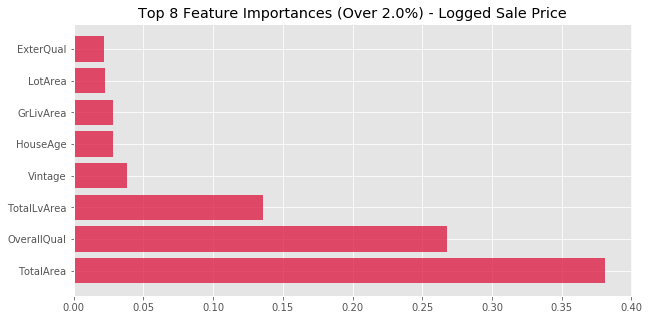

In [38]:
# remove collinear features

lst1_2 = ['TotalArea',
 'TotalLvArea',
 'OverallQual',
 'GrLivArea',
 'Vintage',
 'ExterQual',
#  'YearBuilt',
#  'TotalBsmtSF',
#  'GarageYrBlt',
 'GarageArea',
 'GarageCars',
 'KitchenQual',
#  '1stFlrSF',
 'GarageAge',
 'BsmtQual',
 'HouseAge',
 'FullBath',
 'LotArea',
#  'BsmtFinSF1',
 'Fireplaces',
#  'YearRemodAdd',
 'FireplaceQu',
#  '2ndFlrSF',
 'FireplacesBin']

# run function to get list and rf model
lst1_2_2, rf1_2 = RandForest(rf_x_train[lst1_2], rf_y, 'Logged Sale Price', perc = 0.02, log = True)

# save RF model predict as a csv for submission
rf_y_test = np.exp(rf1_2.predict(rf_x_test[lst1_2]))
sub = pd.DataFrame({'ID': df_test.Id, 'SalePrice': rf_y_test}).set_index('ID')
sub.to_csv('Submission_logPx_RF2.csv')

### Random forest run on PricePerSF

RF oob score: 0.6681
RF score: 0.9552
RF RMSLE: 0.057474
--------------------------------------------------
Top 28 important features by FI: ['YearBuilt', 'Vintage', 'GarageYrBlt', 'BsmtUnfSF', 'OverallQual', 'TotalLvArea', 'GarageAge', 'HouseAge', 'TotalBsmtSF', 'YearRemodAdd', 'OverallCond', 'ExterQual', 'TotalArea', 'BsmtQual', 'KitchenQual', 'GarageArea', 'GrLivArea', 'BsmtFinSF1', '1stFlrSF', 'LotArea', 'BsmtExposure', 'Neighborhood', 'LotFrontage', 'GarageCars', 'OutdoorArea', 'BsmtCond', 'TotRmsAbvGrd', 'Foundation']


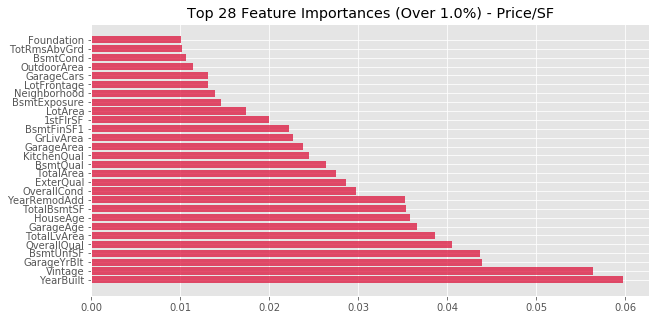

In [42]:
# create response variable on price/sf
rf_y2 = df_train.PricePerSF

# run fucntion and get list of top features
lst2, rf2 = RandForest(rf_x_train, rf_y2, 'Price/SF', log = False)

# save RF model predict as a csv for submission
rf_y_test = np.exp(rf2.predict(rf_x_test))
sub = pd.DataFrame({'ID': df_test.Id, 'SalePrice': rf_y_test}).set_index('ID')
sub.to_csv('Submission_PxSF_RF1.csv')

##### Tune Random Forest based on feature importances obtained above

In [40]:
lst2

['YearBuilt',
 'Vintage',
 'GarageYrBlt',
 'BsmtUnfSF',
 'OverallQual',
 'TotalLvArea',
 'GarageAge',
 'HouseAge',
 'TotalBsmtSF',
 'YearRemodAdd',
 'OverallCond',
 'ExterQual',
 'TotalArea',
 'BsmtQual',
 'KitchenQual',
 'GarageArea',
 'GrLivArea',
 'BsmtFinSF1',
 '1stFlrSF',
 'LotArea',
 'BsmtExposure',
 'Neighborhood',
 'LotFrontage',
 'GarageCars',
 'OutdoorArea',
 'BsmtCond',
 'TotRmsAbvGrd',
 'Foundation']

RF oob score: 0.6850
RF score: 0.9576
RF RMSLE: 0.056116
--------------------------------------------------
Top 16 important features by FI: ['Vintage', 'BsmtUnfSF', 'OverallQual', 'TotalLvArea', 'GarageAge', 'TotalBsmtSF', 'OverallCond', 'HouseAge', 'ExterQual', 'GarageArea', 'LotArea', 'TotalArea', 'LotFrontage', 'KitchenQual', 'Neighborhood', 'BsmtQual']


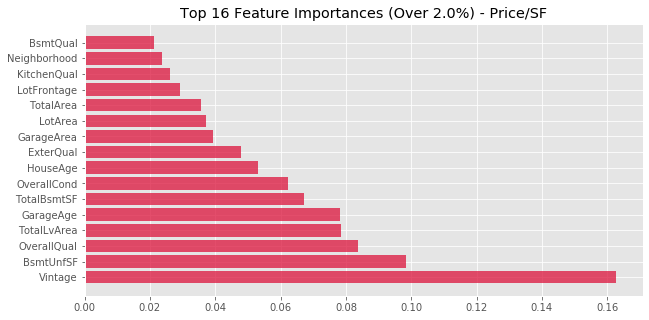

In [43]:
lst2_2 = [#'YearBuilt',
 'Vintage',
#  'GarageYrBlt',
 'BsmtUnfSF',
 'OverallQual',
 'TotalLvArea',
 'GarageAge',
 'HouseAge',
 'TotalBsmtSF',
#  'YearRemodAdd',
 'OverallCond',
 'ExterQual',
 'TotalArea',
 'BsmtQual',
 'KitchenQual',
 'GarageArea',
#  'GrLivArea',
#  'BsmtFinSF1',
#  '1stFlrSF',
 'LotArea',
 'BsmtExposure',
 'Neighborhood',
 'LotFrontage',
 'GarageCars',
#  'OutdoorArea',
 'BsmtCond',
 'TotRmsAbvGrd',
 'Foundation']

# run function to get features and RF regressor
lst2_2_2, rf2_2 = RandForest(rf_x_train[lst2_2], rf_y2, 'Price/SF', 0.02, log = False)

# save RF model predict as a csv for submission
rf_y_test = rf2_2.predict(rf_x_test[lst2_2]) * rf_x_test.TotalLvArea
sub = pd.DataFrame({'ID': df_test.Id, 'SalePrice': rf_y_test}).set_index('ID')
sub.to_csv('Submission_PxSF_RF2.csv')

### 2. Regularization with Lasso

In [45]:
# import libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, LassoCV, ElasticNetCV

In [46]:
# LassoCV()

In [47]:
# define a funciton to repeatedly perform Lasso regularization

def lasso_cv(x, y, alphas = None):
    lasso = LassoCV(alphas = alphas, normalize = True, cv = 5, random_state = 0, max_iter = 100000)
    lasso.fit(x, y)
    coef = pd.Series(lasso.coef_, index = x.columns)
    print('LassoCV Summary:\nR^2:', lasso.score(x, y))
    print('alpha:', lasso.alpha_)
    print('# of non-zero coef:', len(coef[coef != 0]))
    print('-' * 50)
    print(coef[coef != 0])
    pred = lasso.predict(x)
    return coef[coef != 0], pred, lasso

#### Apply regularization (Lasso) to above two selected lists, `lst1_2` and `lst2_2`, and check the performances

In [48]:
# define a function to test RMSLE of Lasso

def lasso_error(dummy_col, feature_lst, log = True):
    agg = pd.concat([df_train, df_test], axis = 0, sort = False)
    
    # separate target varibales of SalePrice and PricePerSF
    y = agg[: 1455].SalePrice
    y_2 = agg[: 1455].PricePerSF
    
    # create dumy variables based on input list
    agg = pd.get_dummies(agg[feature_lst], columns = dummy_col, drop_first = True)
    
    # predictor variables
    x = agg[: 1455]
    
    if log:
        coef, pred, model = lasso_cv(x, np.log(y))
        rmsle = np.sqrt(mean_squared_log_error(y, np.exp(model.predict(x))))
    else:
        coef, pred, model = lasso_cv(x, y_2)
        rmsle = np.sqrt(mean_squared_log_error(y, model.predict(x) * x.TotalLvArea))
    print('\nRMSLE is:', np.round(rmsle, 6))
    
    return model, agg

In [49]:
df_train[lst1_2_2].dtypes

TotalArea      float64
OverallQual      int64
TotalLvArea    float64
Vintage          int64
HouseAge         int64
GrLivArea        int64
LotArea          int64
ExterQual       object
dtype: object

In [57]:
dummy_1 = ['OverallQual', 'ExterQual']
rf_lasso_1, agg1 = lasso_error(dummy_1, lst1_2_2)

LassoCV Summary:
R^2: 0.8600318711758106
alpha: 8.801345527925429e-06
# of non-zero coef: 17
--------------------------------------------------
TotalArea         0.000169
TotalLvArea      -0.000027
Vintage          -0.002168
HouseAge         -0.002158
GrLivArea         0.000095
LotArea           0.000007
OverallQual_2    -0.463538
OverallQual_3    -0.236723
OverallQual_4    -0.100752
OverallQual_6     0.069888
OverallQual_7     0.137031
OverallQual_8     0.235624
OverallQual_9     0.362918
OverallQual_10    0.280292
ExterQual_Fa     -0.281643
ExterQual_Gd     -0.053993
ExterQual_TA     -0.074096
dtype: float64

RMSLE is: 0.149206


In [58]:
df_train[lst2_2_2].dtypes

Vintage           int64
BsmtUnfSF       float64
OverallQual       int64
TotalLvArea     float64
GarageAge       float64
TotalBsmtSF     float64
OverallCond       int64
HouseAge          int64
ExterQual        object
GarageArea      float64
LotArea           int64
TotalArea       float64
LotFrontage     float64
KitchenQual      object
Neighborhood     object
BsmtQual         object
dtype: object

In [59]:
dummy_2 = ['OverallQual', 'OverallCond', 'ExterQual', 'KitchenQual', 'Neighborhood', 'BsmtQual']
rf_lasso_2, agg2 = lasso_error(dummy_2, lst2_2_2, log = False)

LassoCV Summary:
R^2: 0.7373573976779013
alpha: 0.00021164388561804937
# of non-zero coef: 57
--------------------------------------------------
Vintage                 -0.168281
BsmtUnfSF               -0.006064
TotalLvArea             -0.014577
GarageAge               -0.003675
TotalBsmtSF             -0.005487
HouseAge                -0.050455
GarageArea               0.002763
LotArea                  0.000354
TotalArea                0.006760
LotFrontage              0.011923
OverallQual_2          -12.260969
OverallQual_3          -11.822374
OverallQual_4          -10.377653
OverallQual_5           -9.529304
OverallQual_6           -7.055462
OverallQual_7           -2.443943
OverallQual_8            3.566064
OverallQual_9           11.671988
OverallQual_10          18.012650
OverallCond_2           -2.751945
OverallCond_3           -1.839894
OverallCond_5            3.106833
OverallCond_6            6.848142
OverallCond_7           10.464840
OverallCond_8           10.815878
Overa

In [60]:
y_test1 = np.exp(rf_lasso_1.predict(agg1[1455:]))
sub = pd.DataFrame({'ID': df_test.Id, 'SalePrice': y_test1}).set_index('ID')
sub.to_csv('Submission_logPx_RFLasso.csv')

In [61]:
y_test2 = rf_lasso_2.predict(agg2[1455:]) * agg2[1455:].TotalLvArea
sub = pd.DataFrame({'ID': df_test.Id, 'SalePrice': y_test2}).set_index('ID')
sub.to_csv('Submission_pxSF_RFLasso.csv')

In [ ]:
coef1.index

In [ ]:
coef1
np.round(np.exp(pred1), -2)
test_y1 = lasso_agg1[1461:]
model1.predict(test_y1[coef1.index])

In [ ]:
lasso = LassoCV(normalize = True, cv = 5, random_state = 0, max_iter = 100000)
lasso.fit(lasso_x1, rf_y)
lasso.predict(lasso_x1)

#### Lists of categarical and continuous features -> aggregated feature list

In [74]:
feature_cat = ['Neighborhood',
'LandContour',
'Alley',
'HeatingQC',
'MSSubClass',
'MSZoning',
'OverallQual',
'FireplaceQu',
'MasVnrType',
'ExterQual',
'KitchenQual',
'FireplacesBin',
'LotShapeBin',
'PoolBin',
'TotalBath']

feature_con = ['HouseAge',
'Vintage',
'GrLivArea',
'LotArea',
'LotFrontage',
'GarageArea',
'TotalLvArea',
'OutdoorArea']

feature_all = feature_cat + feature_con

len(feature_all)

23

In [44]:
lst1_2_2 and lst2_2_2

['Vintage',
 'BsmtUnfSF',
 'OverallQual',
 'TotalLvArea',
 'GarageAge',
 'TotalBsmtSF',
 'OverallCond',
 'HouseAge',
 'ExterQual',
 'GarageArea',
 'LotArea',
 'TotalArea',
 'LotFrontage',
 'KitchenQual',
 'Neighborhood',
 'BsmtQual']

#### Separating feature and target columns

In [65]:
# X = df_train[feature_all]
# X = pd.get_dummies(X, columns = feature_cat, drop_first = True)
# y = np.log(df_train.SalePrice)

In [68]:
# lasso_cv(X, y)

In [75]:
lasso_1, agg_1 = lasso_error(feature_cat, feature_all, log = True)

y_test = np.exp(lasso_1.predict(agg_1[1455:]))
sub = pd.DataFrame({'ID': df_test.Id, 'SalePrice': y_test}).set_index('ID')
sub.to_csv('Submission_logPx_Lasso.csv')

LassoCV Summary:
R^2: 0.9025590454683425
alpha: 9.716354435318748e-06
# of non-zero coef: 82
--------------------------------------------------
HouseAge               -0.001774
Vintage                -0.001549
GrLivArea               0.000077
LotArea                 0.000003
LotFrontage             0.000229
GarageArea              0.000202
TotalLvArea             0.000112
OutdoorArea             0.000134
Neighborhood_Blueste    0.056247
Neighborhood_BrDale    -0.018538
Neighborhood_BrkSide    0.034010
Neighborhood_ClearCr    0.059301
Neighborhood_Crawfor    0.170880
Neighborhood_Edwards   -0.065951
Neighborhood_Gilbert   -0.010828
Neighborhood_IDOTRR    -0.031808
Neighborhood_MeadowV   -0.110817
Neighborhood_Mitchel   -0.026852
Neighborhood_NAmes      0.003252
Neighborhood_NPkVill    0.063506
Neighborhood_NWAmes    -0.003252
Neighborhood_NoRidge    0.085069
Neighborhood_NridgHt    0.063182
Neighborhood_OldTown   -0.043475
Neighborhood_Sawyer    -0.020524
Neighborhood_SawyerW   -0.00303

In [77]:
lasso_2, agg_2 = lasso_error(feature_cat, feature_all, log = False)

y_test = lasso_2.predict(agg_2[1455:]) * agg_2[1455:].TotalLvArea
sub = pd.DataFrame({'ID': df_test.Id, 'SalePrice': y_test}).set_index('ID')
sub.to_csv('Submission_PxSF_Lasso.csv')

LassoCV Summary:
R^2: 0.7129251203023381
alpha: 0.0007431222617792676
# of non-zero coef: 85
--------------------------------------------------
HouseAge                -0.107160
Vintage                 -0.113336
GrLivArea                0.012288
LotArea                  0.000295
LotFrontage              0.001123
GarageArea               0.011492
TotalLvArea             -0.021096
OutdoorArea              0.008035
Neighborhood_Blueste     2.778190
Neighborhood_BrDale      0.472714
Neighborhood_BrkSide     4.641172
Neighborhood_ClearCr     3.951332
Neighborhood_Crawfor    11.900404
Neighborhood_Edwards    -3.032573
Neighborhood_Gilbert    -0.249330
Neighborhood_IDOTRR     -1.635148
Neighborhood_MeadowV    -5.862822
Neighborhood_Mitchel    -2.410531
Neighborhood_NAmes       1.144265
Neighborhood_NPkVill     4.337732
Neighborhood_NWAmes     -0.180073
Neighborhood_NoRidge     9.821499
Neighborhood_NridgHt     4.582713
Neighborhood_OldTown    -1.420094
Neighborhood_SWISU       1.441443
Neighb

In [ ]:
# alphas = np.linspace(0.05, 20, 400)
# lasso_cv(X, y, alphas = alphas)

### Test the assumptions of linear models
- Linearity
- Normality
- Homoscedaciticity
- Independence
- Milticolinearity

In [ ]:
feature_selected, pred = lasso_cv(X, y)

In [ ]:
pred_error = y - pred
feature_con_sel = (feature_selected.index & feature_con).tolist()
feature_con_sel

In [ ]:
sns.distplot(pred_error)
sns.kdeplot(pred_error, shade = True, Label = 'Residual of Price')

In [ ]:
pred_error.skew()

In [ ]:
sns.jointplot

In [ ]:
for f in feature_con_sel:
    sns.jointplot(df_train[f], y, kind = 'reg', ratio = 4, space = 0.1)

In [ ]:
df_train.head()